In [1]:
using DynamicalSystems, Plots, NPZ
include("../src/KoopmanCausality.jl")
using .KoopmanCausality

## Coupled Rossler

In [2]:
ω1 = 0.8
ω2 = 0.5
a = 0.2
b = 0.2
c = 5.3
k2 = 0.0
k1 = 0.5

u0=[1, -2, 0, 0.11, 0.2, 0.1]
ds = Systems.coupled_roessler(u0; ω1, ω2, a, b, c, k1, k2)

6-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  coupled_roessler_f
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [0.8, 0.5, 0.2, 0.2, 5.3, 0.5, 0.0]
 time:          0.0
 state:         [1.0, -2.0, 0.0, 0.11, 0.2, 0.1]


### training data

In [3]:
T_evolv = 5_010.0
time_step = 0.01
transient_time = 2_000.0
orbit, t = trajectory(ds, T_evolv; Δt=time_step, Ttr=transient_time)
data = permutedims(Matrix(orbit))
T = size(data, 2)

501001

In [4]:
Δ = 1000; # time lag for prediction

In [5]:
X = Array{Float32}(undef, 6, T-Δ)
Y = Array{Float32}(undef, 6, T-Δ)

for t in 1:(T-Δ)
	X[:, t] = data[:, t]
	Y[:, t] = data[:, t+Δ]
end

X1 = X[1:3, :]
Y1 = Y[1:3, :]
X2 = X[4:end, :]
Y2 = Y[4:end, :];

In [6]:
println(size(X1))
println(size(X2))
println(size(Y1))
println(size(Y2))

(3, 500001)
(3, 500001)
(3, 500001)
(3, 500001)


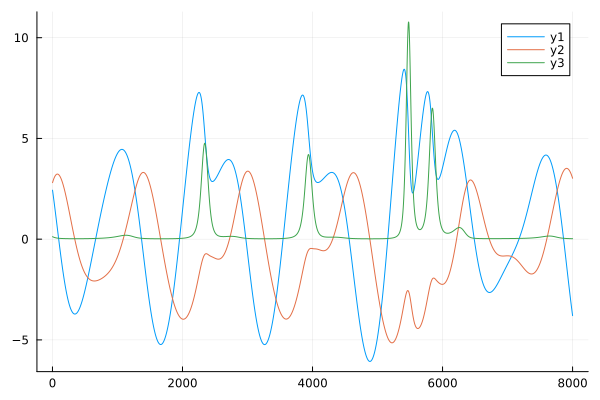

In [7]:
Plots.plot(X1[1, 1:8000])
Plots.plot!(X1[2, 1:8000])
Plots.plot!(X1[3, 1:8000])

In [8]:
npzwrite("coupled_rossler_data/coupled_rossler_train_X1.npy", X1)
npzwrite("coupled_rossler_data/coupled_rossler_train_X2.npy", X2)
npzwrite("coupled_rossler_data/coupled_rossler_train_Y1.npy", Y1)
npzwrite("coupled_rossler_data/coupled_rossler_train_Y2.npy", Y2);

### test data

In [9]:
Ntrials = 100
T_evolv = 210.0
time_step = 0.01
T = 20_001
X1 = Array{Float64}(undef, 3, T, Ntrials)
X2 = Array{Float64}(undef, 3, T, Ntrials)
Y1 = Array{Float64}(undef, 3, T, Ntrials)
Y2 = Array{Float64}(undef, 3, T, Ntrials)
size(X1)

(3, 20001, 100)

ergodic random sampling of initial conditions via random transient time

In [11]:
for n in 1:Ntrials
	transient_time = Int(floor(rand()*10000))
	orbit, t = trajectory(ds, T_evolv; Δt=time_step, Ttr=transient_time)
	data = permutedims(Matrix(orbit))
    X = Array{Float32}(undef, 6, T)
    Y = Array{Float32}(undef, 6, T)
    for t in 1:T
    	X[:, t] = data[:, t]
    	Y[:, t] = data[:, t+Δ]
    end
    X1[:, :, n] = X[1:3, :]
    Y1[:, :, n] = Y[1:3, :]
    X2[:, :, n] = X[4:end, :]
    Y2[:, :, n] = Y[4:end, :]
end

In [12]:
println(size(X1))
println(size(X2))
println(size(Y1))
println(size(Y2))

(3, 20001, 100)
(3, 20001, 100)
(3, 20001, 100)
(3, 20001, 100)


In [13]:
npzwrite("coupled_rossler_data/coupled_rossler_test_X1.npy", X1)
npzwrite("coupled_rossler_data/coupled_rossler_test_X2.npy", X2)
npzwrite("coupled_rossler_data/coupled_rossler_test_Y1.npy", Y1)
npzwrite("coupled_rossler_data/coupled_rossler_test_Y2.npy", Y2);

Plot a few 

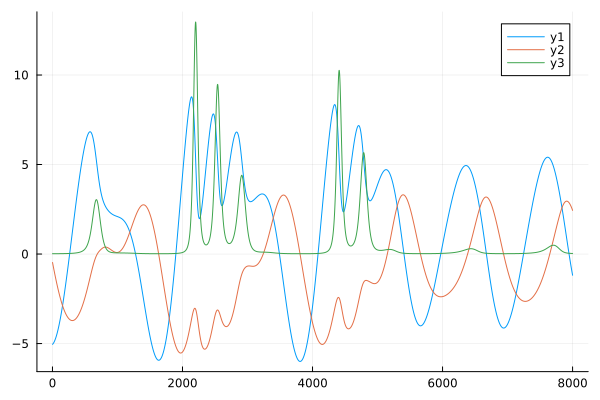

In [14]:
trial = 1
Plots.plot(X1[1, 1:8000, trial])
Plots.plot!(X1[2, 1:8000, trial])
Plots.plot!(X1[3, 1:8000, trial])

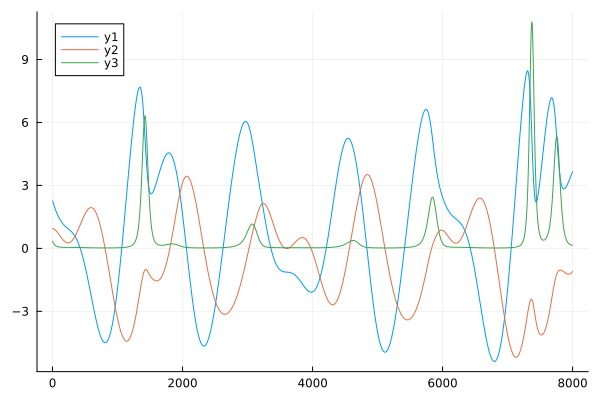

In [15]:
trial = 2
Plots.plot(X1[1, 1:8000, trial])
Plots.plot!(X1[2, 1:8000, trial])
Plots.plot!(X1[3, 1:8000, trial])

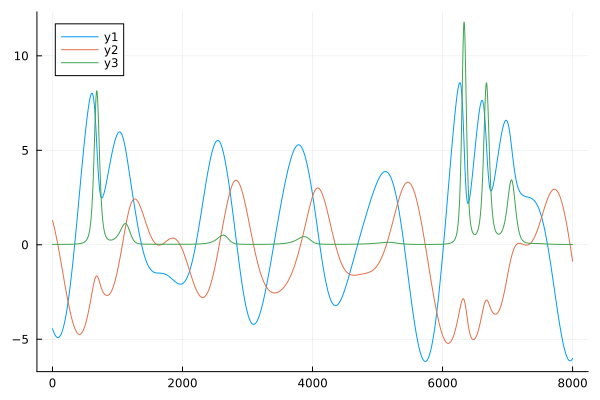

In [16]:
trial = 3
Plots.plot(X1[1, 1:8000, trial])
Plots.plot!(X1[2, 1:8000, trial])
Plots.plot!(X1[3, 1:8000, trial])

# Rossler Confounder

In [17]:
function roessler_confounder(u,p,t)
    ω1, ω2, ω3, a, b, c, k12, k13 = p

    du1 = -ω1*u[2] - u[3]
    du2 = ω1*u[1] + a*u[2] 
    du3 = b + u[3]*(u[1]-c)
    
    du4 = -ω2*u[5] - u[6]
    du5 = ω2*u[4] + a*u[5] + k12*(u[2]-u[5])
    du6 = b + u[6]*(u[4]-c)
    
    du7 = -ω3*u[8] - u[9]
    du8 = ω3*u[7] + a*u[8] + k13*(u[2]-u[8])
    du9 = b + u[9]*(u[7]-c)
    return SVector(du1,du2,du3,du4,du5,du6,du7,du8,du9)
end

roessler_confounder (generic function with 1 method)

In [18]:
ω1 = 0.8
ω2 = 0.5
ω3 = 0.5
a = 0.2
b = 0.2
c = 5.3
k12 = 0.5
k13 = 0.5

u0=[1, -2, 0, 0.11, 0.2, 0.1, -0.11, 0.3, 0.0]
p = (ω1,ω2,ω3,a,b,c,k12,k13)
ds = CoupledODEs(roessler_confounder, u0, p)

9-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  roessler_confounder
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    (0.8, 0.5, 0.5, 0.2, 0.2, 5.3, 0.5, 0.5)
 time:          0.0
 state:         [1.0, -2.0, 0.0, 0.11, 0.2, 0.1, -0.11, 0.3, 0.0]


### training data

In [19]:
T_evolv = 5_010.0
time_step = 0.01
transient_time = 2_000.0
orbit, t = trajectory(ds, T_evolv; Δt=time_step, Ttr=transient_time)
data = permutedims(Matrix(orbit))
T = size(data, 2)

501001

In [20]:
Δ = 1000; # time lag for prediction

In [21]:
X = Array{Float32}(undef, 9, T-Δ)
Y = Array{Float32}(undef, 9, T-Δ)

for t in 1:(T-Δ)
	X[:, t] = data[:, t]
	Y[:, t] = data[:, t+Δ]
end

X1 = X[1:3, :]
Y1 = Y[1:3, :]
X2 = X[4:6, :]
Y2 = Y[4:6, :]
X3 = X[7:end, :]
Y3 = Y[7:end, :];

In [22]:
println(size(X1))
println(size(X2))
println(size(X3))
println(size(Y1))
println(size(Y2))
println(size(Y3))

(3, 500001)
(3, 500001)
(3, 500001)
(3, 500001)
(3, 500001)
(3, 500001)


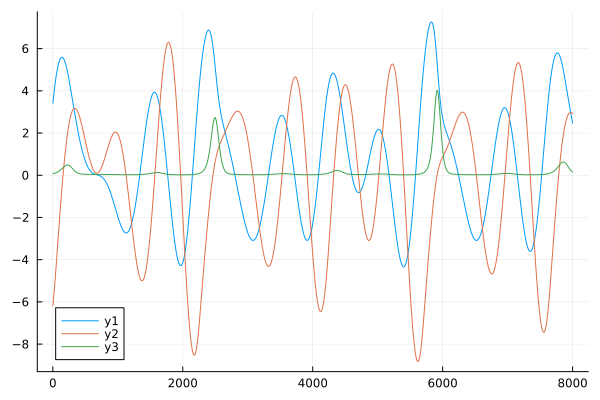

In [23]:
Plots.plot(X3[1, 1:8000])
Plots.plot!(X3[2, 1:8000])
Plots.plot!(X3[3, 1:8000])

In [24]:
npzwrite("rossler_confounder_data/rossler_confounder_train_X1.npy", X1)
npzwrite("rossler_confounder_data/rossler_confounder_train_X2.npy", X2)
npzwrite("rossler_confounder_data/rossler_confounder_train_X3.npy", X3)
npzwrite("rossler_confounder_data/rossler_confounder_train_Y1.npy", Y1)
npzwrite("rossler_confounder_data/rossler_confounder_train_Y2.npy", Y2)
npzwrite("rossler_confounder_data/rossler_confounder_train_Y3.npy", Y3);

### test data

In [32]:
Ntrials = 100
T_evolv = 210.0
time_step = 0.01
T = 20_001
X1 = Array{Float64}(undef, 3, T, Ntrials)
X2 = Array{Float64}(undef, 3, T, Ntrials)
X3 = Array{Float64}(undef, 3, T, Ntrials)
Y1 = Array{Float64}(undef, 3, T, Ntrials)
Y2 = Array{Float64}(undef, 3, T, Ntrials)
Y3 = Array{Float64}(undef, 3, T, Ntrials)
size(X3)

(3, 20001, 100)

ergodic random sampling of initial conditions via random transient time

In [33]:
for n in 1:Ntrials
	transient_time = Int(floor(rand()*10000))
	orbit, t = trajectory(ds, T_evolv; Δt=time_step, Ttr=transient_time)
	data = permutedims(Matrix(orbit))
    X = Array{Float32}(undef, 9, T)
    Y = Array{Float32}(undef, 9, T)
    for t in 1:T
    	X[:, t] = data[:, t]
    	Y[:, t] = data[:, t+Δ]
    end
    X1[:, :, n] = X[1:3, :]
    Y1[:, :, n] = Y[1:3, :]
    X2[:, :, n] = X[4:6, :]
    Y2[:, :, n] = Y[4:6, :]
    X3[:, :, n] = X[7:end, :]
    Y3[:, :, n] = Y[7:end, :]
end

In [34]:
println(size(X1))
println(size(X2))
println(size(X3))
println(size(Y1))
println(size(Y2))
println(size(Y3))

(3, 20001, 100)
(3, 20001, 100)
(3, 20001, 100)
(3, 20001, 100)
(3, 20001, 100)
(3, 20001, 100)


In [35]:
npzwrite("rossler_confounder_data/rossler_confounder_test_X1.npy", X1)
npzwrite("rossler_confounder_data/rossler_confounder_test_X2.npy", X2)
npzwrite("rossler_confounder_data/rossler_confounder_test_X3.npy", X3)
npzwrite("rossler_confounder_data/rossler_confounder_test_Y1.npy", Y1)
npzwrite("rossler_confounder_data/rossler_confounder_test_Y2.npy", Y2)
npzwrite("rossler_confounder_data/rossler_confounder_test_Y3.npy", Y3);

Plot a few 

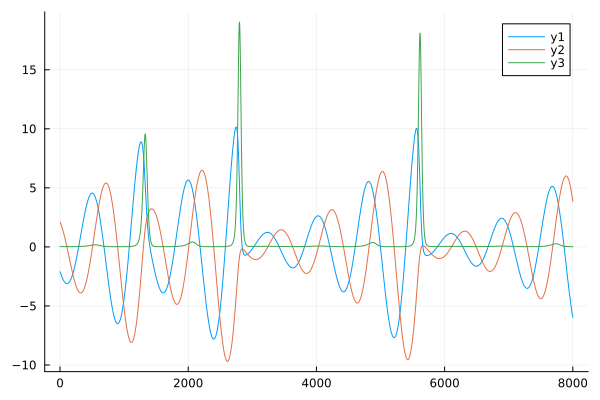

In [36]:
trial = 1
Plots.plot(X1[1, 1:8000, trial])
Plots.plot!(X1[2, 1:8000, trial])
Plots.plot!(X1[3, 1:8000, trial])

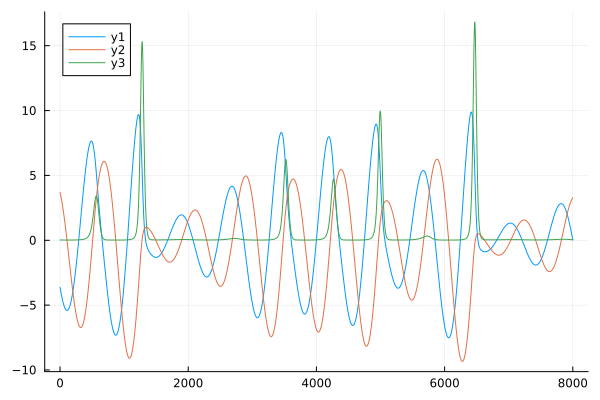

In [37]:
trial = 2
Plots.plot(X1[1, 1:8000, trial])
Plots.plot!(X1[2, 1:8000, trial])
Plots.plot!(X1[3, 1:8000, trial])

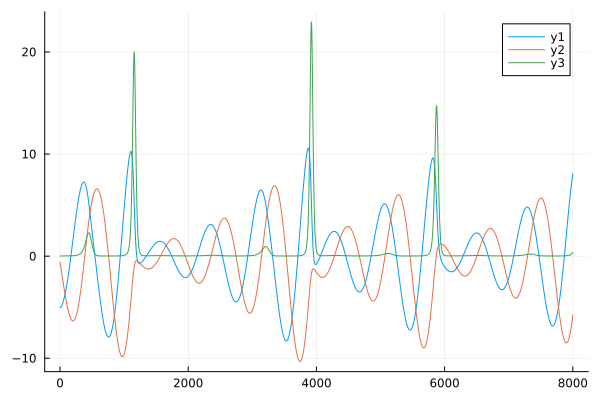

In [38]:
trial = 3
Plots.plot(X1[1, 1:8000, trial])
Plots.plot!(X1[2, 1:8000, trial])
Plots.plot!(X1[3, 1:8000, trial])